This notebook will be used to determine the intial concentration of medicine required when considering the case of our real-world data research, and non-constant blood flow model

This notebook has two components:

1. A step-by-step run through of the functionality to make sure it works
2. An optimisation technique to solve the problem, obtain a $C_0$, and plot results 

# Model Set-Up

We will use the Backward Euler method as we will not have to consider the stability criterion when we change the blood flow (advection term).

We will use the same model parameters as we used in the *verify_analytical_solution.ipynb* notebook. 

## Connection to Real World Data

### Diffusion
Research presented a diffusion coefficient:

$
D = 6.7 \times 10^{-10} \, \text{m}^2/\text{s}\
$


### Advection
Research on different vein types from a specified injection points showed the following piecewise (under the assumption the time to heart is still 60 seconds)

$$
v(t) = 
\begin{cases} 
0.1  & \text{if } 0 \leq t < 59.82 \\ 
0.38 & \text{if } 59.82 \leq t < 60
\end{cases}
m/s
$$

From this can also define the following
$$
v(x) = 
\begin{cases} 
0.1  & \text{if } 0 \leq x < 5.982 \\ 
0.38 & \text{if } 5.982 \leq x < 6.052
\end{cases}
m
$$

Where the new heart location is $x = 6.052$ m




## Non-Constant Blood Flow

### Challenge of implementing the Non-Constant Blood Flow:

The advection term, is of course dependent on the blood flow. For each point in time we will need to update
$$
A = v*dt/(2*dx)
$$

### Model

$$
v(t) = v_{mean} + B * sin(\frac{2\pi f_{heart}}{60}t + \phi)
$$

Where,


$$
\begin{aligned}
v_{mean} &= X \frac{m}{s} \text{, dependent on type of vein}\\
B &= \text{amplitude of fluctuation, assume to be 0.1 for now} \\
f_{heart} &= \text{resting heart rate, human average is between 60 and 100 bpm} \\
t &= \text{time in seconds} \\
\phi &= \text{phase shift (where in } f_{\text{heart}} \text{ cycle are you, assume to be zero)}
\end{aligned}
$$


# Code

In [19]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import functions as f

In [5]:
save_fig = False

### Non-Constant Blood Flow as a function of time

In [17]:
def v_t(t, f_heart=80, B=0.05, phi=0):
    
    # Initialise
    v = np.zeros_like(t)
    
    # Piece-wise if statement depending on vein type, set v_mean
    v[t <= 59.82] = 0.1
    v[t > 59.82] = 0.38
    
    # Sinusoidal model
    v += B*np.sin( ((2*np.pi*f_heart)/60)*t + phi)
    
    return v

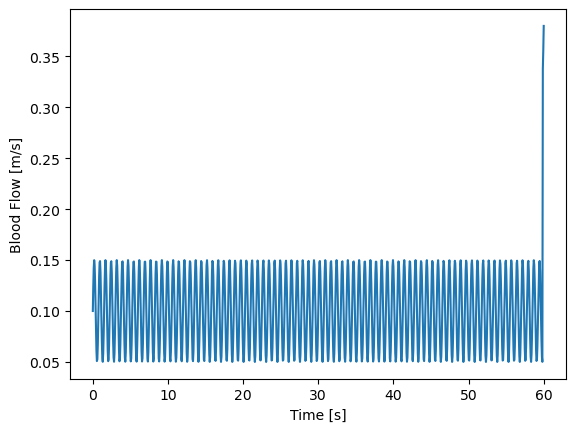

In [18]:
# Plot the non-constant blood flow model

t = np.linspace(0,60,1000)
blood_flow = v_t(t)
fig, ax = plt.subplots()
ax.plot(t, blood_flow)

ax.set_xlabel('Time [s]')
ax.set_ylabel('Blood Flow [m/s]')

plt.show()


# Define Parameters

Use the same parameters as defined for Backwards Euler as in *verify_analytical_solution.ipynb*.

In [ ]:
# t parameters
Nt_gaps = 800    # number of timesteps
T = 60             # final time 

Nt_points = Nt_gaps + 1
t = np.linspace(0.,T,Nt_points)  # times at each time step
dt = t[1] - t[0]

# x parameters
Nx_spaces = 800;   # number of spaces in x
L1 = -10; # Distance behind 0 reference point
L2 = 25 # Distance in front  0 reference point

Nx_points = Nx_spaces + 1 
x = np.linspace(L1, L2, Nx_points)    # mesh points in space
dx = x[1] - x[0]


# Input conditions
C0 = 8.713e-3 # What we want to find to get Cf_desired, use our old 
Cf_desired = 1e-3 # Problem definition 
D = 6.7e-10 # new diffusion coefficient
heart_loc = 6.052 # new heart location

b0 = 0
bL = 0

Define the *A* term for advection (it now changes with time)

In [ ]:
A = blood_flow*dt/(2*dx)

# Also get our constant, C
C = D*dt/(dx**2)


0.0019140624999999377

# Run Backward Euler with Matrices

Since our term, *A* is changing each time iteration, we will need to define a new matrix at each time step.

In [30]:
def I(x, C0): # initial u(x,0)
    u = np.zeros_like(x)
    
    # where x is between 0 and 1, set to C0
    u[(x >= 0) & (x <= 1)] = C0
    return u

In [31]:
def build_A_mat(C, A, Nx_points):
    # Data structures for the linear system
    A_mat = np.zeros((Nx_points, Nx_points))
    
    for i in range(1, Nx_points-1):
        A_mat[i,i-1] = -C - A
        A_mat[i,i+1] = -C + A
        A_mat[i,i] = 1 + 2*C
        
    # implement the (constant-in-time) Dirichlet conditions
    A_mat[0,0] = 1
    A_mat[Nx_points-1,Nx_points-1] = 1
    
    return A_mat

In [33]:
# set up matrices for single time solutions and the full solution
u   = np.zeros(Nx_points)
u_old = np.zeros(Nx_points)

U = np.zeros((Nx_points,Nt_points))
U_ex = np.zeros((Nx_points, Nt_points))

# Data structures for the linear system
b = np.zeros(Nx_points)

# Set initial condition u(x,0) = I(x)
u_old = I(x, C0)

# initialise matrices for storing solutions
U[:,0] = u_old

# do timestepping 
for n in range(1, Nt_points):
    
    # Compute b and solve linear system
    b[1:Nx_points-2] = u_old[1: Nx_points-2]  # internal values
    b[0] = b0  # boundary conditions  
    b[-1] = bL
    
    # Build new matrix
    A_mat = build_A_mat(C, A[n], Nx_points)

    # update u by solving the matrix system Au = b
    u_new = np.linalg.solve(A_mat,b)
    
    # Update u_old before next step
    u_old = u_new
    U[:,n] = u_new    

# Find the final concentration at the heart
index_closest = (np.abs(x - heart_loc)).argmin()
Cf = U[index_closest, -1]

# Print the results
diff = (Cf - Cf_desired)

print(f'Cf = {Cf}')

print(f'Difference between Cf and desired Cf: {diff}')

Cf = 0.005592580654305043
Difference between Cf and desired Cf: 0.004592580654305043
